In [1]:
import numpy as np
from sklearn.cluster import k_means

def bkmeans(X:np.ndarray, k:int, i:int) -> np.ndarray:
    """Bisecting k-Means"""
    res = np.zeros(X.shape[0], dtype=int)
    for kk in range(1, k):
        values, counts = np.unique(res, return_counts=True)
        most_common_k = values[counts.argmax()]
        most_common_indices = res == most_common_k
        new_clusters = k_means(X[most_common_indices], 2, n_init=i)[1]
        res[most_common_indices] = np.where(new_clusters == 0, most_common_k, kk)
    return res

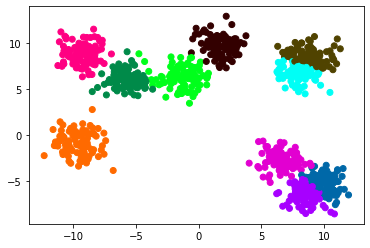

In [2]:
from colormap import generate_colormap
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

X, y = make_blobs(n_samples=1000, centers=10, n_features=2)
k = 10
c = bkmeans(X, k, 100)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=c, cmap=generate_colormap(k))
plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

def sammons_stress(in_X, out_X):
    """Calculate Sammon's Stress"""
    S = np.triu(in_X)
    d = np.triu(out_X)
    return (1 / np.sum(S)) * np.sum(np.divide(np.square(d - S), S, out=np.zeros_like(S), where=S!=0))

def sammon(X, max_iter=100, epsilon=0.01, alpha=0.3, init="random", verbose=False):
    """Sammon Mapping"""
    S = pairwise_distances(X)
    S = np.where(S==0, 1e-100, S)
    c = np.sum(np.triu(S))
    y_indices = range(X.shape[0])

    if init == "pca":
        Y = PCA(n_components=2, random_state=1).fit_transform(X)
    else:
        Y = make_blobs(n_samples=X.shape[0], n_features=2, centers=1, random_state=1337)[0]

    for t in range(max_iter):
        d = pairwise_distances(Y)
        d = np.where(d==0, 1e-100, d)
        E = sammons_stress(S, d)
        if verbose:
            print(f"Iter: {t}, E = {E}")
        if E < epsilon:
            print(f"Error threshold of {epsilon}, reached at iter {t}. E = {E}")
            break

        for i in y_indices:
            first = np.array([0, 0], dtype=np.float64)
            second = np.array([0, 0], dtype=np.float64)
            for j in y_indices:
                if j == i: continue
                first += ((S[i,j] - d[i,j]) / (d[i,j] * S[i,j])) * (Y[i] - Y[j])
                second += (1 / (S[i,j] * d[i,j])) * ( (S[i,j] - d[i,j]) - ((np.square(Y[i] - Y[j]) / d[i,j]) * (1 + ( (S[i,j] - d[i,j]) / d[i,j] ))) )
            
            Y[i] = Y[i] - alpha * ((-2/c)*first)/np.abs((-2/c)*second)
    return Y

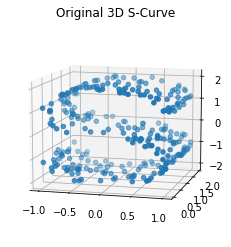

Iter: 0, E = 0.6390167608805878
Iter: 1, E = 0.5175148005749113
Iter: 2, E = 0.40612169133714593
Iter: 3, E = 0.3984854560220881
Iter: 4, E = 0.8242515864190099
Iter: 5, E = 0.815392495840205
Iter: 6, E = 0.3934202564914064
Iter: 7, E = 0.6581460336508639
Iter: 8, E = 2.2875512414144494
Iter: 9, E = 37.61581145892169
Iter: 10, E = 0.13924886420471572
Iter: 11, E = 0.2836469047713173
Iter: 12, E = 0.06175176264341181
Iter: 13, E = 0.03711349529307709
Iter: 14, E = 0.12943485602174357
Iter: 15, E = 0.03167975170605403
Iter: 16, E = 0.027404909329568267
Iter: 17, E = 0.030302637600516692
Iter: 18, E = 0.024473008415141703
Iter: 19, E = 0.023656812164454005
Iter: 20, E = 0.024411275157692276
Iter: 21, E = 0.023264267138415878
Iter: 22, E = 0.022975026269898155
Error threshold of 0.023, reached at iter 22. E = 0.022975026269898155


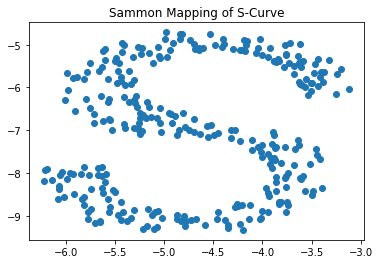

In [4]:
from sklearn.datasets import make_s_curve

X, y = make_s_curve(300, random_state=1)

fig = plt.figure("Original 3D S-Curve")
ax = fig.add_subplot(projection="3d")
ax.title.set_text("Original 3D S-Curve")
ax.view_init(10, 285)
ax.scatter(X[:,0], X[:,1], X[:,2])
plt.show()

Y = sammon(X, max_iter=50, epsilon=0.023, alpha=1, verbose=True)
plt.figure("Sammon Mapping of S-Curve")
plt.title("Sammon Mapping of S-Curve")
plt.scatter(Y[:,0], Y[:,1])

plt.show()

C:\Users\olofe\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Iter: 0, E = 0.9841608609304249
Iter: 1, E = 1.0625022761765175
Iter: 2, E = 0.9728075570391254
Iter: 3, E = 0.9524899540512173
Iter: 4, E = 0.933938144010808
Iter: 5, E = 0.9650469666234078
Iter: 6, E = 1.0486328387480726
Iter: 7, E = 25.467185698964304
Iter: 8, E = 1.0962080541177337
Iter: 9, E = 1.5911099844678427
Iter: 10, E = 1.0487747381320298
Iter: 11, E = 130.17770776222255
Iter: 12, E = 1.4559187624652454
Iter: 13, E = 0.83791157025057
Iter: 14, E = 3.927316184959712
Iter: 15, E = 2.616713054367248
Iter: 16, E = 0.9828201095113155
Iter: 17, E = 0.5952931004429778
Iter: 18, E = 13.719225267440574
Iter: 19, E = 0.9015779008997152
Iter: 20, E = 0.7196718926918437
Iter: 21, E = 0.7944336034499346
Iter: 22, E = 0.3821715895231355
Iter: 23, E = 0.303721401429696
Iter: 24, E = 0.8626088907857273
Iter: 25, E = 0.22179835094184056
Iter: 26, E = 0.4380270832320908
Iter: 27, E = 0.10250408117664962
Iter: 28, E = 0.06989898378241664
Iter: 29, E = 0.052991338576873534
Iter: 30, E = 0.07061

C:\Users\olofe\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Iter: 0, E = 0.9742497095910126
Iter: 1, E = 0.9809712439833362
Iter: 2, E = 0.9640760796364107
Iter: 3, E = 0.9408290168379684
Iter: 4, E = 0.8908097829429776
Iter: 5, E = 0.8915340616264941
Iter: 6, E = 0.8441133144364731
Iter: 7, E = 0.8925325697894003
Iter: 8, E = 1.0070488006965137
Iter: 9, E = 1.033917388144414
Iter: 10, E = 0.8507241006388221
Iter: 11, E = 0.7845486250524156
Iter: 12, E = 0.7403802907443595
Iter: 13, E = 0.9688073155363957
Iter: 14, E = 1.0526444089248475
Iter: 15, E = 1.6840507230875676
Iter: 16, E = 1.6964137850920264
Iter: 17, E = 1.1454257730604964
Iter: 18, E = 2.7279059915961703
Iter: 19, E = 1.5748128576543485
Iter: 20, E = 208.31300939574936
Iter: 21, E = 102.20878961658865
Iter: 22, E = 50.9405388135943
Iter: 23, E = 25.238021534902703
Iter: 24, E = 12.504961402719028
Iter: 25, E = 6.245879311792974
Iter: 26, E = 3.417103175531408
Iter: 27, E = 1.8033543512980064
Iter: 28, E = 1.137881110214049
Iter: 29, E = 0.7504658600384748
Iter: 30, E = 0.5091390128

C:\Users\olofe\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Iter: 0, E = 0.32756740043112637
Iter: 1, E = 1.2893738512252786
Iter: 2, E = 0.35650324572699993
Iter: 3, E = 0.49815369857186176
Iter: 4, E = 0.4841243822533696
Iter: 5, E = 1.1590203454695855
Iter: 6, E = 1.4210344576285352
Iter: 7, E = 3.7216253262746553
Iter: 8, E = 0.3688398645433393
Iter: 9, E = 31.430321154192654
Iter: 10, E = 0.25914366034988917
Iter: 11, E = 0.32952552452709116
Iter: 12, E = 1.2833818441279208
Iter: 13, E = 0.20554485363982064
Iter: 14, E = 0.19335828065772503
Iter: 15, E = 0.24955791818200762
Iter: 16, E = 8.287060320450987
Iter: 17, E = 0.35982716045980134
Iter: 18, E = 0.15583493694492742
Iter: 19, E = 0.35718982027412643
Iter: 20, E = 0.2506365893233299
Iter: 21, E = 0.16918603044830902
Iter: 22, E = 22.098816721326024
Iter: 23, E = 0.3448924762530272
Iter: 24, E = 0.10671521102112252
Iter: 25, E = 0.5273797409333094
Iter: 26, E = 7.701796755082438
Iter: 27, E = 0.2698517287682397
Iter: 28, E = 0.4413132362720732
Iter: 29, E = 0.11159748901938413
Iter: 30

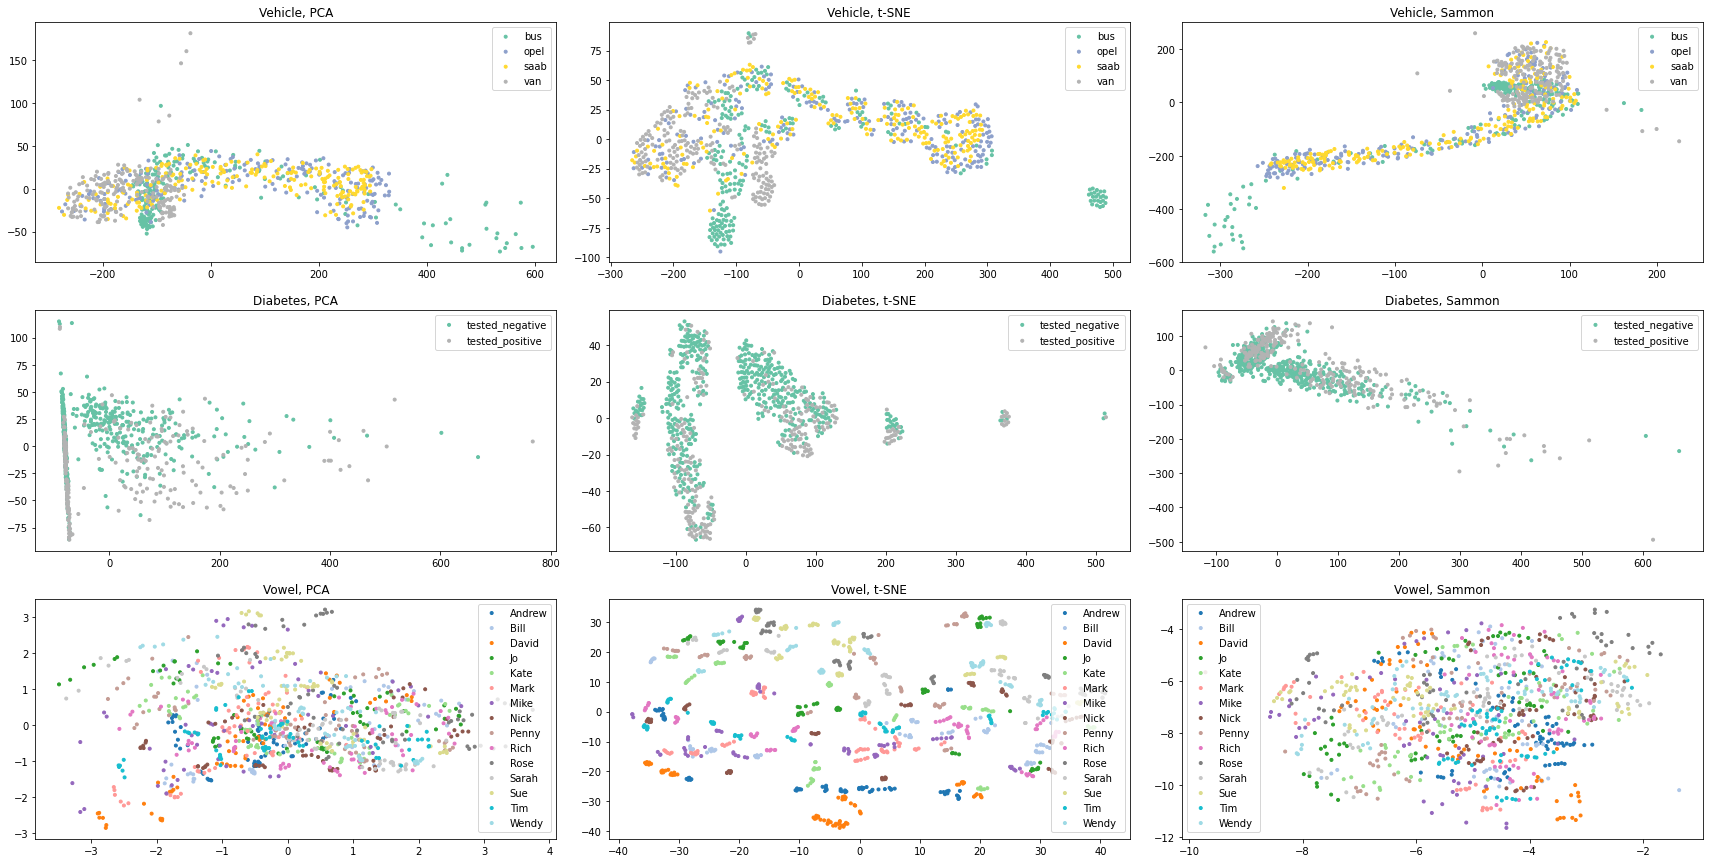

In [18]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
from scipy.io import arff

def plot(X, y, plt_i, labels, cmap, norm, title):
    plt.subplot(3, 3, plt_i)
    plt.title(title)
    for i, l in enumerate(labels):
        plt.scatter(X[y==i, 0], X[y==i, 1], c=cmap(norm(y[y==i])), label=l, marker=".")
    plt.legend()


plt.figure(figsize=(24, 12))

cmap = get_cmap("Set2")

data = np.array(arff.loadarff("data/vehicle.arff")[0].tolist())
X_v, classes = np.array(data[:, :-1], dtype=np.float64), np.array(data[:, -1], dtype=str)
labels_v, y_v = np.unique(classes, return_inverse=True)
norm_v = Normalize(vmin=0, vmax=3)

data = np.array(arff.loadarff("data/diabetes.arff")[0].tolist())
X_d, classes = np.array(data[:, :-1], dtype=np.float64), np.array(data[:, -1], dtype=str)
labels_d, y_d = np.unique(classes, return_inverse=True)
norm_d = Normalize(vmin=0, vmax=1)

data = np.array(arff.loadarff("data/vowel.arff")[0].tolist())
X_vo, classes = np.array(data[:, 2:-1], dtype=np.float64), np.array(data[:, 0], dtype=str)
labels_vo, y_vo = np.unique(classes, return_inverse=True)
cmap_vo = get_cmap("tab20")
norm_vo = Normalize(vmin=0, vmax=14)

Y_v_p = PCA(n_components=2).fit_transform(X_v)
Y_v_t = TSNE(n_components=2, init="pca", learning_rate="auto").fit_transform(X_v)
Y_v_s = sammon(X_v, max_iter=50, epsilon=0.01, alpha=1, verbose=True)

Y_d_p = PCA(n_components=2).fit_transform(X_d)
Y_d_t = TSNE(n_components=2, init="pca", learning_rate="auto").fit_transform(X_d)
Y_d_s = sammon(X_d, max_iter=50, epsilon=0.01, alpha=0.3, verbose=True)

Y_vo_p = PCA(n_components=2).fit_transform(X_vo)
Y_vo_t = TSNE(n_components=2, init="pca", learning_rate="auto").fit_transform(X_vo)
Y_vo_s = sammon(X_vo, max_iter=50, epsilon=0.01, alpha=1, verbose=True)

plot(Y_v_p, y_v, 1, labels_v, cmap, norm_v, "Vehicle, PCA")
plot(Y_v_t, y_v, 2, labels_v, cmap, norm_v, "Vehicle, t-SNE")
plot(Y_v_s, y_v, 3, labels_v, cmap, norm_v, "Vehicle, Sammon")

plot(Y_d_p, y_d, 4, labels_d, cmap, norm_d, "Diabetes, PCA")
plot(Y_d_t, y_d, 5, labels_d, cmap, norm_d, "Diabetes, t-SNE")
plot(Y_d_s, y_d, 6, labels_d, cmap, norm_d, "Diabetes, Sammon")

plot(Y_vo_p, y_vo, 7, labels_vo, cmap_vo, norm_vo, "Vowel, PCA")
plot(Y_vo_t, y_vo, 8, labels_vo, cmap_vo, norm_vo, "Vowel, t-SNE")
plot(Y_vo_s, y_vo, 9, labels_vo, cmap_vo, norm_vo, "Vowel, Sammon")


plt.subplots_adjust(left=0.025, bottom=0.025, right=0.99, top=0.97, wspace=0.1, hspace=0.2)
plt.show()

## 3.1
1. For the vehicle dataset I would say t-SNE performed the best.  
   Again, t-SNE seems to perform better for the diabetes dataset. Sammon performs okay, zooming in shows that the overlapping is not as bad as it seems.  
   Looking at the vowel dataset, both PCA and Sammon is pretty chaotic, hard to distinguish any real grouping. So, t-SNE performs better once again.
2. The vowel dataset (CHANGE IT TO USE THE CLASSES FOR Y)